In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely import wkt
from shapely.geometry import Polygon
from geowrangler import distance_zonal_stats as dzs

/mnt/c/Users/JCPeralta/Documents/GitHub/geoml-starter-test/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
RAW_DIR = "../../../data/tm/1-raw/"
PROCESSED_DIR = "../../../data/tm/2-processed/"

# Create proximity attribute columns per tile
This notebook adds columns containing distances to certain key locations from the tile centroid. These key locations are:

- Central Business Districts (CBDs)
- City center
- Wide greenspaces
- Major roads

## 1. Read tiles

In [2]:
tile_df = pd.read_csv(f"{PROCESSED_DIR}ctt-tiles/tile_bounds_revised_raw.csv")
tile_df["geometry"] = tile_df["geometry"].apply(wkt.loads)

tile_gdf = gpd.GeoDataFrame(tile_df, geometry="geometry")
tile_gdf = tile_gdf.rename(columns={"city": "city_name"})
tile_gdf = tile_gdf.set_crs(4326)
tile_gdf = tile_gdf.to_crs(epsg=3122)
tile_gdf.head()

,tile_id,city_name,n_footprints_estimate,geometry
0,T00001,Dagupan,50-100,"POLYGON ((644869.932 1778803.179, 645110.281 1..."
1,T00002,Dagupan,50-100,"POLYGON ((642772.600 1777088.170, 643012.747 1..."
2,T00003,Dagupan,50-100,"POLYGON ((642496.103 1775173.492, 642737.868 1..."
3,T00004,Dagupan,100-200,"POLYGON ((645768.161 1775113.995, 646024.662 1..."
4,T00005,Dagupan,50-100,"POLYGON ((642082.494 1775086.238, 642323.416 1..."


## 2. Read attributes

#### Read central business district

In [3]:
cbd_gdf = gpd.read_file(f"{PROCESSED_DIR}proximity_areas/cbds.geojson").to_crs(3122)
cbd_gdf.head()

,id,name,geometry
0,8,Ayala Business Park Davao,"MULTIPOLYGON (((1231856.011 789495.714, 123186..."
1,1,Ortigas,"MULTIPOLYGON (((721207.400 1613629.502, 721372..."
2,2,Bonifacio Global City,"MULTIPOLYGON (((720076.507 1610811.484, 720147..."
3,3,Makati,"MULTIPOLYGON (((717102.552 1610312.672, 716970..."
4,4,Filinvest,"MULTIPOLYGON (((720423.455 1596046.418, 720439..."


#### Read city center

In [4]:
cc_gdf = gpd.read_file(
    f"{PROCESSED_DIR}proximity_areas/city_center_buffered.geojson"
).to_crs(3122)
cc_gdf.head()

,id,city_name,geometry
0,1,Dagupan CIty,"MULTIPOLYGON (((643257.881 1774890.167, 643251..."
1,2,Palayan City,"MULTIPOLYGON (((724235.802 1720422.479, 724229..."
2,3,Navotas City,"MULTIPOLYGON (((710199.175 1622049.492, 710193..."
3,4,Mandaluyong City,"MULTIPOLYGON (((719534.730 1613234.324, 719528..."
4,5,Muntinlupa City,"MULTIPOLYGON (((720848.574 1593017.420, 720842..."


#### Read greenspace

In [5]:
gs_gdf = gpd.read_file(f"{PROCESSED_DIR}proximity_areas/greenspaces.geojson").to_crs(
    3122
)
# Filter areas smaller than 0.5ha
print(len(gs_gdf))
gs_gdf["area"] = gs_gdf.geometry.area
gs_gdf = gs_gdf[gs_gdf["area"] > 5000]
print(len(gs_gdf))
gs_gdf.head()

89
76


,id,name,geometry,area
0,1,Navotas Green Zone Park,"MULTIPOLYGON (((709834.623 1621015.082, 709837...",10966.451911
1,2,Camp Aguinaldo Golf Course,"MULTIPOLYGON (((721513.658 1616554.148, 721629...",380014.986553
2,3,Daza Park,"MULTIPOLYGON (((722398.969 1616007.423, 722499...",15257.099886
3,4,Green Meadows Clubhouse,"MULTIPOLYGON (((723610.620 1615299.802, 723497...",12187.601824
4,5,Corinthian Gardens Park,"MULTIPOLYGON (((722306.609 1615011.060, 722307...",54133.570654


#### Read roads

In [6]:
roads_gdf = gpd.read_file(
    f"{PROCESSED_DIR}proximity_areas/hotosm_roads_lacuna_cities_prime_buffered_200m.geojson"
).to_crs(3122)
roads_gdf.head()

,osm_id,highway,width,name,lanes,smoothness,surface,layer,source,bridge,oneway,geometry
0,4086429.0,primary,None,Shaw Boulevard,2,None,asphalt,None,None,None,yes,"MULTILINESTRING ((718260.735 1615008.574, 7182..."
1,4263551.0,secondary,None,Makati-Mandaluyong Bridge,2,None,asphalt,1,None,yes,yes,"MULTILINESTRING ((718728.671 1612180.646, 7187..."
2,4263552.0,secondary,None,Makati-Mandaluyong Bridge,1,None,None,None,None,None,yes,"MULTILINESTRING ((718799.957 1612403.574, 7188..."
3,4263555.0,secondary,None,San Francisco Avenue,3,None,asphalt,None,None,None,yes,"MULTILINESTRING ((718973.301 1613127.256, 7189..."
4,4263556.0,secondary,None,Maysilo Circle,3,None,asphalt,None,None,None,yes,"MULTILINESTRING ((719055.757 1613085.677, 7190..."


## 3. Measure distance to nearest key location

In [7]:
def get_nearest_distance(aoi_gdf, data_gdf, col_name, fill=False):
    dist_col_name = f"{col_name}_nearest"
    gdf = dzs.create_distance_zonal_stats(
        aoi_gdf,
        data_gdf,
        max_distance=10000,
        aggregations=[],
        distance_col=dist_col_name,
    )
    if fill:
        gdf = gdf.fillna(10000)
    return gdf

In [8]:
tile_prox_gdf = get_nearest_distance(tile_gdf, cbd_gdf, "cbd")
tile_prox_gdf = get_nearest_distance(tile_prox_gdf, cc_gdf, "city_center")
tile_prox_gdf = get_nearest_distance(tile_prox_gdf, gs_gdf, "greenspace")
tile_prox_gdf = get_nearest_distance(tile_prox_gdf, roads_gdf, "main_road")
tile_prox_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 122 entries, 0 to 121
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   tile_id                122 non-null    object  
 1   city_name              122 non-null    object  
 2   n_footprints_estimate  122 non-null    object  
 3   geometry               122 non-null    geometry
 4   cbd_nearest            34 non-null     float64 
 5   city_center_nearest    104 non-null    float64 
 6   greenspace_nearest     106 non-null    float64 
 7   main_road_nearest      122 non-null    float64 
dtypes: float64(4), geometry(1), object(3)
memory usage: 8.6+ KB


array([[<AxesSubplot: title={'center': 'cbd_nearest'}>,
        <AxesSubplot: title={'center': 'city_center_nearest'}>],
       [<AxesSubplot: title={'center': 'greenspace_nearest'}>,
        <AxesSubplot: title={'center': 'main_road_nearest'}>]],
      dtype=object)

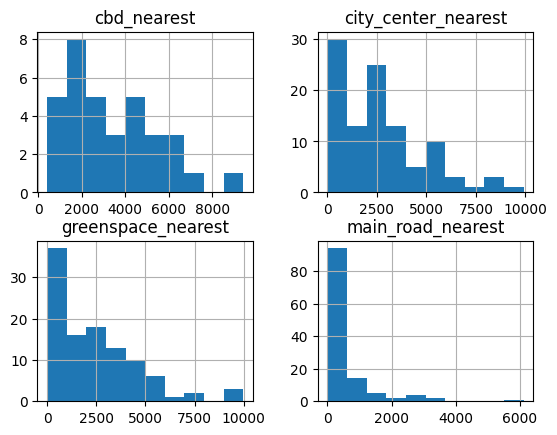

In [9]:
tile_prox_gdf[
    ["cbd_nearest", "city_center_nearest", "greenspace_nearest", "main_road_nearest"]
].hist()

In [10]:
prox_cols = [
    "cbd_nearest",
    "city_center_nearest",
    "greenspace_nearest",
    "main_road_nearest",
]
tile_prox_gdf = tile_prox_gdf.fillna(10000)
tile_prox_gdf[prox_cols] = tile_prox_gdf[prox_cols].round(1)
tile_prox_gdf

,tile_id,city_name,n_footprints_estimate,geometry,cbd_nearest,city_center_nearest,greenspace_nearest,main_road_nearest
0,T00001,Dagupan,50-100,"POLYGON ((644869.932 1778803.179, 645110.281 1...",10000.0,3946.8,4448.8,275.8
1,T00002,Dagupan,50-100,"POLYGON ((642772.600 1777088.170, 643012.747 1...",10000.0,1698.1,2171.8,0.0
2,T00003,Dagupan,50-100,"POLYGON ((642496.103 1775173.492, 642737.868 1...",10000.0,0.0,257.4,162.3
3,T00004,Dagupan,100-200,"POLYGON ((645768.161 1775113.995, 646024.662 1...",10000.0,2520.1,3053.4,0.0
4,T00005,Dagupan,50-100,"POLYGON ((642082.494 1775086.238, 642323.416 1...",10000.0,0.0,316.7,0.0
...,...,...,...,...,...,...,...,...
117,T00118,Zamboanga,100-200,"POLYGON ((840735.736 767117.866, 840984.266 76...",10000.0,2170.8,2859.5,0.0
118,T00119,Zamboanga,100-200,"POLYGON ((833358.899 767072.795, 833607.414 76...",10000.0,6316.6,1155.3,114.4
119,T00120,Zamboanga,100-200,"POLYGON ((848011.375 766262.603, 848259.925 76...",10000.0,7743.4,7717.7,1991.0
120,T00121,Zamboanga,100-200,"POLYGON ((845910.890 765439.867, 846159.440 76...",10000.0,5529.5,5479.5,2584.9


In [11]:
tile_prox_gdf["near_city_center"] = tile_prox_gdf["city_center_nearest"].apply(
    lambda x: 1 if x < 2000 else 0
)
tile_prox_gdf["near_wide_greenspace"] = tile_prox_gdf["greenspace_nearest"].apply(
    lambda x: 1 if x < 500 else 0
)
tile_prox_gdf["near_cbd"] = tile_prox_gdf["cbd_nearest"].apply(
    lambda x: 1 if x < 2000 else 0
)
tile_prox_gdf["near_main_road"] = tile_prox_gdf["main_road_nearest"].apply(
    lambda x: 1 if x < 200 else 0
)

In [12]:
tile_prox_gdf.columns

Index(['tile_id', 'city_name', 'n_footprints_estimate', 'geometry',
       'cbd_nearest', 'city_center_nearest', 'greenspace_nearest',
       'main_road_nearest', 'near_city_center', 'near_wide_greenspace',
       'near_cbd', 'near_main_road'],
      dtype='object')

In [13]:
cols_to_keep = [
    "tile_id",
    "city_name",
    "n_footprints_estimate",
    "geometry",
    "cbd_nearest",
    "city_center_nearest",
    "greenspace_nearest",
    "main_road_nearest",
    "near_city_center",
    "near_wide_greenspace",
    "near_cbd",
    "near_main_road",
]

In [14]:
tile_prox_gdf = tile_prox_gdf[cols_to_keep].to_crs(epsg=4326)
tile_prox_gdf.head()

,tile_id,city_name,n_footprints_estimate,geometry,cbd_nearest,city_center_nearest,greenspace_nearest,main_road_nearest,near_city_center,near_wide_greenspace,near_cbd,near_main_road
0,T00001,Dagupan,50-100,"POLYGON ((120.35530 16.07866, 120.35754 16.078...",10000.0,3946.8,4448.8,275.8,0,0,0,0
1,T00002,Dagupan,50-100,"POLYGON ((120.33560 16.06329, 120.33784 16.063...",10000.0,1698.1,2171.8,0.0,1,0,0,1
2,T00003,Dagupan,50-100,"POLYGON ((120.33290 16.04601, 120.33516 16.046...",10000.0,0.0,257.4,162.3,1,1,0,1
3,T00004,Dagupan,100-200,"POLYGON ((120.36347 16.04528, 120.36586 16.045...",10000.0,2520.1,3053.4,0.0,0,0,0,1
4,T00005,Dagupan,50-100,"POLYGON ((120.32903 16.04524, 120.33128 16.045...",10000.0,0.0,316.7,0.0,1,1,0,1


## 4. Save

In [15]:
tile_prox_gdf.to_csv(f"{PROCESSED_DIR}ctt-tiles/tile_bounds.csv", index=False)